<a href="https://colab.research.google.com/github/vivianngo97/COVID-19-X-ray-Classifier/blob/master/Copy_of_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly --quiet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from typing import Optional, List, Callable
import numpy as np
import pandas as pd
import shutil, os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import glob
tf.__version__

'2.4.0-dev20200708'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [ ]:
 # %cd /content/gdrive/My\ Drive/ # need to mount to Google Drive
os.chdir("/content/gdrive/My Drive/Colab Notebooks/covid-chestxray-dataset-master/COVID19_images") ### for my testing
!pwd # should see /content/gdrive/My Drive

/content/gdrive/My Drive/Colab Notebooks/covid-chestxray-dataset-master/COVID19_images


In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/covid-chestxray-dataset-master/COVID19_images'

In [ ]:
!ls images_directory

bacterial  covid  healthy


In [ ]:
image_size = (160, 160)
image_shape = image_size + (3,)
batch_size = 32 

# training set 
train_ds = tf.keras.preprocessing.image_dataset_from_directory('images_directory',
    validation_split=0.2, subset='training', seed=1337,
    image_size=image_size, batch_size=batch_size)

# validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   'images_directory', validation_split=0.2, subset='validation', seed=1337,
    image_size=image_size, batch_size=batch_size)

for image_batch, label_batch in train_ds.take(1):
   pass

Found 4754 files belonging to 3 classes.
Using 3804 files for training.
Found 4754 files belonging to 3 classes.
Using 950 files for validation.


In [ ]:
#type(train_ds)
train_ds.take(1)

<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

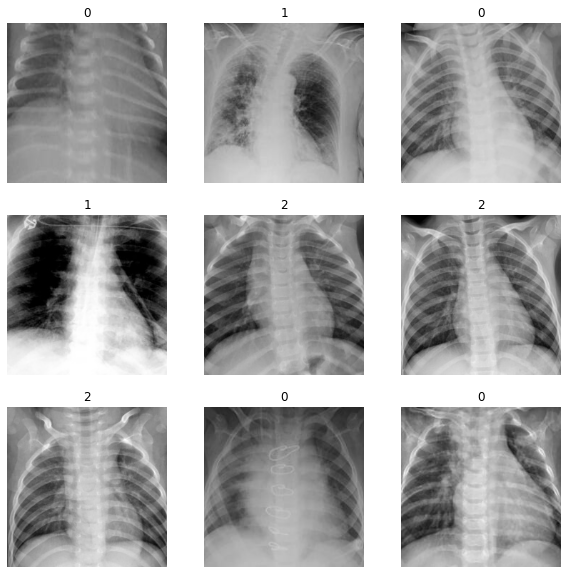

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

In [ ]:
# function to perform data augmentation 
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

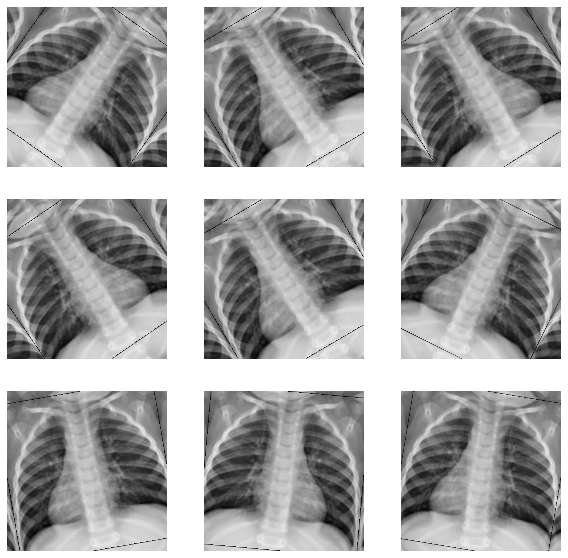

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images) # see the augmented images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#base_model.trainable = True
base_model.summary()

In [ ]:
# I assume that this is not usable?
#base_model = keras.models.load_model("brucechou1983_CheXNet_Keras_0.3.0_weights.h5")
#base_model.trainable = True
#base_model.summary()

In [ ]:
for images, labels in train_ds.take(1):
  print(labels)

tf.Tensor([2 0 0 1 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 2 0 2 2 0 0 2 2 0 0 0 2], shape=(32,), dtype=int32)


In [ ]:
feature_batch = base_model(images)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False # Freeze the outer model

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
# using RMSProp
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
model.summary() # mobilenetv2_1.00_160 <- transfer learning, pretrained ConvNet
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

20/20 [==============================] - 284s 14s/step - loss: 1.3020 - accuracy: 0.2047


In [ ]:
# using Adam - recommended by some people
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
model.summary() # mobilenetv2_1.00_160 <- transfer learning, pretrained ConvNet
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
20/20 [==============================] - 417s 21s/step - loss: 2.1845 - accuracy: 0.5750


In [ ]:
# using custom loss function
base_learning_rate = 0.005 #0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=weighted_ce, # custom loss function
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])
model.summary() # mobilenetv2_1.00_160 <- transfer learning, pretrained ConvNet
initial_epochs = 20
validation_steps= 20
#history = model.fit(train_ds,batch_size=32)##,
                            #epochs=initial_epochs) #,
                            #verbose=1)
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
[<tf.Tensor 'weighted_ce/Sum:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_1:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_2:0' shape=() dtype=float32>]
sum_loss: 0
sum_loss: Tensor("weighted_ce/add_3:0", shape=(), dtype=float32)
sum_loss: Tensor("weighted_ce/add_4:0", shape=(), dtype=float32)
Tensor("weighted_ce/add_5:0", shape=(), dtype=float32)


In [ ]:
# doesn't work
# using custom loss function and precision metric - need to make custom function
base_learning_rate = 0.005 #0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=weighted_ce, # custom loss function
              metrics=[tf.keras.metrics.Precision()])
model.summary() # mobilenetv2_1.00_160 <- transfer learning, pretrained ConvNet
initial_epochs = 20
validation_steps= 20

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    verbose=1)


In [ ]:
type(p)
p.shape #  n by 3, probabilities of being in each class
val_ds
counts = [0, 0, 0]
for element in val_ds.as_numpy_iterator(): 
  for c in range(3):
    try: 
      counts[c] += pd.Series(element[-1]).value_counts()[c]
    except: 
      pass
print(counts)
# what does the target look like? - want to get the counts of 0s, 1s, and 2s



[560, 75, 315]


In [ ]:
# validation set 
val_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
   'images_directory', validation_split=0.2, subset='validation', seed=1337,
    image_size=image_size, batch_size=batch_size)

Found 4754 files belonging to 3 classes.
Using 950 files for validation.


In [ ]:
val_ds.batch

<bound method DatasetV2.batch of <PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>>

In [ ]:
counts = [0, 0, 0]
for element in train_ds.as_numpy_iterator(): 
  for c in range(3):
    try: 
      counts[c] += pd.Series(element[-1]).value_counts()[c]
    except: 
      pass
print(counts)

KeyboardInterrupt: ignored

In [ ]:
for images, labels in val_ds.unbatch().take(-1):  
    numpy_labels = labels.numpy()
    #print(numpy_labels)

In [ ]:
# customized loss function
def weighted_ce(targets, predictions):
    """
    Weighted categorical cross entropy function.
    """
    #print(time.strftime("%Y%m%d-%H%M%S") + " weighted cross entropy \n")
    #counts = tf.math.reduce_sum(targets, [0, 1])
    #print("type(targets)")
    #print(type(targets))
    #print(targets)
    #print("start counts")
    counts = [0, 0, 0]
    def tf_count(t, val):
      elements_equal_to_value = tf.equal(t, val)
      as_ints = tf.cast(elements_equal_to_value, tf.float32)
      count = tf.math.reduce_sum(as_ints)
      return count
    for c in range(3):
      try: 
        counts[c] = tf_count(targets, c)
      except:
        pass
    #counts[c] = 0 # already true
    #counts[1] = tf_count(targets, 1)
    #counts[2] = tf_count(targets, 2)
    print(counts)
    weights = [1 / (count ** 0.8 + 1) for count in counts]  ###### CAN ALTER THIS, especially the 0.8
    loss = tf.keras.losses.sparse_categorical_crossentropy(targets, predictions)
    #print(time.strftime("%Y%m%d-%H%M%S") + " weighted cross entropy: start loop \n")
    custom_loss = 0
    for i in range(3):  # 3 total classes
        current_weight = weights[i]
        argmax_targets = tf.argmax(targets, axis=-1)
        current_mask = tf.cast(argmax_targets == i, tf.float32)
        current_loss = current_weight * current_mask * loss
        sum_loss = tf.math.reduce_sum(current_loss)
        print("sum_loss:", custom_loss)
        custom_loss += sum_loss
    print(custom_loss)
    return custom_loss
    # https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras



In [ ]:
# not important 
condf = tf.convert_to_tensor([[1,2,3,4],[4,0,2,1],[1,3,0,2]])
condf = tf.one_hot(condf, axis=-1, depth=5)
cond_pred = tf.random.uniform(minval=0.,maxval=1., shape=(3,4,5))
condf
cond_pred

print(tf.math.reduce_sum(condf, [0,1]))

print(condf)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.30
initial accuracy: 0.50


In [ ]:
#history = model.fit(train_ds,
#                    epochs=initial_epochs,
#                    validation_data=val_ds)

Epoch 1/10
119/119 [==============================] - 1213s 10s/step - loss: 0.8813 - accuracy: 0.6067 - val_loss: 0.7320 - val_accuracy: 0.6800
Epoch 2/10
119/119 [==============================] - 13s 107ms/step - loss: 0.6433 - accuracy: 0.7250 - val_loss: 0.6113 - val_accuracy: 0.7421
Epoch 3/10
119/119 [==============================] - 13s 110ms/step - loss: 0.5399 - accuracy: 0.7655 - val_loss: 0.5425 - val_accuracy: 0.7716
Epoch 4/10
119/119 [==============================] - 13s 108ms/step - loss: 0.4709 - accuracy: 0.8031 - val_loss: 0.4863 - val_accuracy: 0.7937
Epoch 5/10
119/119 [==============================] - 15s 126ms/step - loss: 0.4239 - accuracy: 0.8328 - val_loss: 0.4514 - val_accuracy: 0.8063
Epoch 6/10
119/119 [==============================] - 13s 109ms/step - loss: 0.3899 - accuracy: 0.8525 - val_loss: 0.4280 - val_accuracy: 0.8284
Epoch 7/10
119/119 [==============================] - 13s 110ms/step - loss: 0.3639 - accuracy: 0.8607 - val_loss: 0.4003 - val_ac

Here is the non pre-trained model.

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)

  # Entry block
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Project residual
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes
  
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)


In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

epochs = 5  # In practice you will need at least 50 epochs

callbacks = [
  keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/5
119/119 [==============================] - 48s 405ms/step - loss: 0.4637 - accuracy: 0.8318 - val_loss: 1.7162 - val_accuracy: 0.5895
Epoch 2/5
119/119 [==============================] - 46s 386ms/step - loss: 0.3409 - accuracy: 0.8649 - val_loss: 2.8704 - val_accuracy: 0.5895
Epoch 3/5
119/119 [==============================] - 45s 382ms/step - loss: 0.2976 - accuracy: 0.8846 - val_loss: 3.6306 - val_accuracy: 0.5895
Epoch 4/5
119/119 [==============================] - 46s 385ms/step - loss: 0.2728 - accuracy: 0.8943 - val_loss: 3.3244 - val_accuracy: 0.5968
Epoch 5/5
119/119 [==============================] - 46s 387ms/step - loss: 0.2530 - accuracy: 0.9072 - val_loss: 1.8973 - val_accuracy: 0.6463


In [ ]:
# our function without pre-trained model 
# using custom loss function
model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)
epochs = 10  # In practice you will need at least 50 epochs
callbacks = [
  keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=weighted_ce,
              metrics=['accuracy'])
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
[<tf.Tensor 'weighted_ce/Sum:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_1:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_2:0' shape=() dtype=float32>]
sum_loss: 0
sum_loss: Tensor("weighted_ce/add_3:0", shape=(), dtype=float32)
sum_loss: Tensor("weighted_ce/add_4:0", shape=(), dtype=float32)
Tensor("weighted_ce/add_5:0", shape=(), dtype=float32)
[<tf.Tensor 'weighted_ce/Sum:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_1:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_2:0' shape=() dtype=float32>]
sum_loss: 0
sum_loss: Tensor("weighted_ce/add_3:0", shape=(), dtype=float32)
sum_loss: Tensor("weighted_ce/add_4:0", shape=(), dtype=float32)
Tensor("weighted_ce/add_5:0", shape=(), dtype=float32)
119/119 [==============================] - ETA: 0s - loss: 1.2041 - accuracy: 0.8441[<tf.Tensor 'weighted_ce/Sum:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_1:0' shape=() dtype=float32>, <tf.Tensor 'weighted_ce/Sum_2:0' shape=() dtype=fl